In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [2]:
from helper_fns_plotting import *

# LSFF: generate input data coverage maps for gbd risk factors & causes

pulls shapefiles and input data for the GBD models for:

- Neural Tube Defects (cause)

plots choropleths with countries relevant to LSFF model of number of rows of input data per country on a log scale.

see 2021_01_15_LSFF_GBD_risks_and_causes_model_input_data_density_maps_topcoding for analogous maps in which we topcoded countries above some threshold.

In [3]:
## load relevant countries
import pickle
data_prep_dir = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/'

with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)

countries = [i for i in country_vehicle_map.keys() if type(i)==str]

In [4]:
# plinds pulled / saved these
input_data_path = "/home/j/Project/simulation_science/lsff/GBD 2019 input data/causes_input_data.csv"
causes = pd.read_csv(input_data_path)

input_data_path = "/home/j/Project/simulation_science/lsff/GBD 2019 input data/risk_factor_input_data.csv"
risks = pd.read_csv(input_data_path)

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df = pd.concat([risks,causes])

In [6]:
usecols = ['Location','Cause','Risk','Year Start','Year End','Sex','Age Start','Age End','Representativeness', 'Urbanicity Type',
       'Population Representativeness Covariates', 'Sample Size','Sample Size Unit', 'Standard Error', 'Country']
df[usecols].head()

,Location,Cause,Risk,Year Start,Year End,Sex,Age Start,Age End,Representativeness,Urbanicity Type,Population Representativeness Covariates,Sample Size,Sample Size Unit,Standard Error,Country
0,Angola,NaN,Vitamin A deficiency,1998,1998,Females,1.0,5.0,Unknown,Unknown,NaN,765,people,0.300101,Angola
1,Angola,NaN,Vitamin A deficiency,1998,1998,Males,1.0,5.0,Unknown,Unknown,NaN,765,people,0.293531,Angola
2,Bangladesh,NaN,Vitamin A deficiency,2002,2002,Males,5.0,10.0,Unknown,Unknown,NaN,579,people,0.136488,Bangladesh
3,Bangladesh,NaN,Vitamin A deficiency,2002,2002,Females,5.0,10.0,Unknown,Unknown,NaN,579,people,0.142426,Bangladesh
4,Bangladesh,NaN,Vitamin A deficiency,1999,1999,Females,15.0,20.0,Unknown,Unknown,NaN,30.3365,people,0.072998,Bangladesh


In [7]:
# make names uniform
location_name_map = {    
    'Angola': 'Angola',
    'Bangladesh': 'Bangladesh',
    'Burkina Faso': 'Burkina Faso',
    "Côte d'Ivoire": "Côte d'Ivoire",
    'Cameroon': 'Cameroon',
    'China': 'China',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Egypt': 'Egypt',
    'Ethiopia': 'Ethiopia',
    'Ghana': 'Ghana',
    'India': 'India',
    'Indonesia': 'Indonesia',
    'Kenya': 'Kenya',
    'Madagascar': 'Madagascar',
    'Mozambique': 'Mozambique',
    'Nepal': 'Nepal',
    'Nigeria': 'Nigeria',
    'Pakistan': 'Pakistan',
    'South Africa': 'South Africa',
    'Sudan': 'Sudan',
    'Uganda': 'Uganda',
    'United Republic of Tanzania': 'United Republic of Tanzania',
    'Viet Nam': 'Vietnam',
    'Myanmar': 'Myanmar',
    'Niger': 'Niger'
}

df['location_name'] = df.Country.map(location_name_map)

In [8]:
# count #rows of data per country per cause or risk
data_density = df.copy()
data_density['nrows'] = 1
data_density.loc[data_density.Cause.isna(),'Cause'] = 'NA'
data_density.loc[data_density.Risk.isna(),'Risk'] = 'NA'
data_density = data_density[['Cause','Risk','location_name','nrows']].groupby(by = ['Cause','Risk','location_name'], as_index=False).sum()

In [9]:
## get shapefiles

In [10]:
import geopandas as gpd, matplotlib as mpl, matplotlib.backends.backend_pdf

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.name = world.name.astype(str)

world.loc[world.name=="Dem. Rep. Congo",'name'] = 'Democratic Republic of the Congo'
world.loc[world.name=="Tanzania",'name'] = 'United Republic of Tanzania'
world.rename(columns = {'name':'location_name'}, inplace=True)

In [15]:
# make sure names align for merge
assert len([i for i in data_density.location_name.unique() if i not in world.location_name.unique()])==0

shapefiles = world.merge(data_density, on = 'location_name', how = 'right')

In [17]:
# add log var
shapefiles['log_nrows'] = np.log(shapefiles.nrows)

In [20]:
cause_n_colors_dict = {
    'Dietary iron deficiency':6,
    'Vitamin A deficiency':5,
    'Zinc deficiency':5,
    'Neural tube defects':6
}

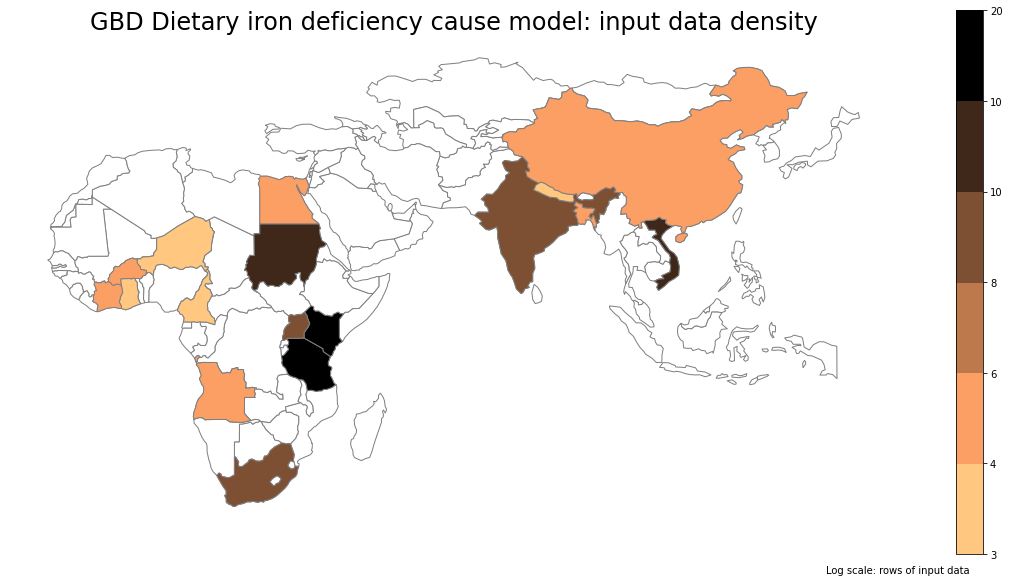

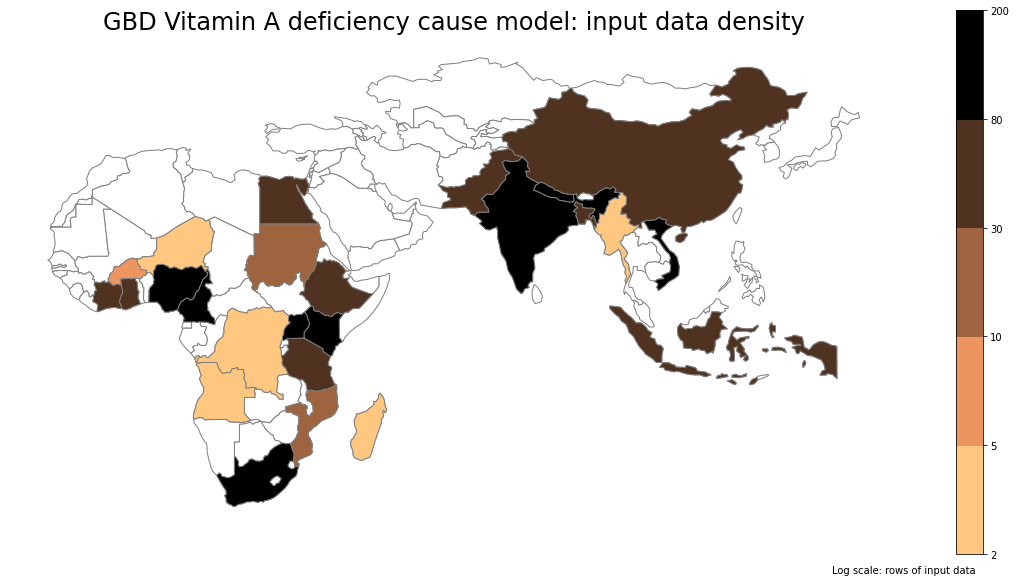

In [21]:
def map_cause_input_data_density(cause, n_colors):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_aspect('equal')
    ax.set_title(f'GBD {cause} cause model: input data density', fontsize = 24)
    ax.set_axis_off() #remove latlon ticks + box surrounding map


    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax,
                                                               color = 'white',
                                                               edgecolor='gray')
    # subset to var of interest
    rf_df = shapefiles[shapefiles.Cause==cause]
    scale_max = rf_df.log_nrows.max()
    scale_min = rf_df.log_nrows.min()

    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('copper_r', n_colors) #colorscale, discretized to n_colors bins
    norm = mpl.colors.Normalize(vmin=scale_min, vmax=scale_max) #normalize color scale
    me = rf_df.plot(ax=base,
                    column='log_nrows',
                    cmap=cmap,
                    edgecolor = 'gray')
    
    # add colorbar
    ticks = np.arange(scale_min, scale_max+1, (scale_max - scale_min)/n_colors)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=me, ticks = ticks)
    
    # exponentiate and round to clean - looking numbers for labeling
    tick_labels = [str(round_ticks(np.exp(i))) for i in ticks]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.set_label('Log scale: rows of input data', labelpad=-105, y=-.02, rotation=0)

save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/gbd_cause_iron_vad_input_data_density_map.pdf'

pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
for cause in ['Dietary iron deficiency', 'Vitamin A deficiency']:
    fig =  map_cause_input_data_density(cause, n_colors = cause_n_colors_dict[cause])
    pdf.savefig(fig)
pdf.close()

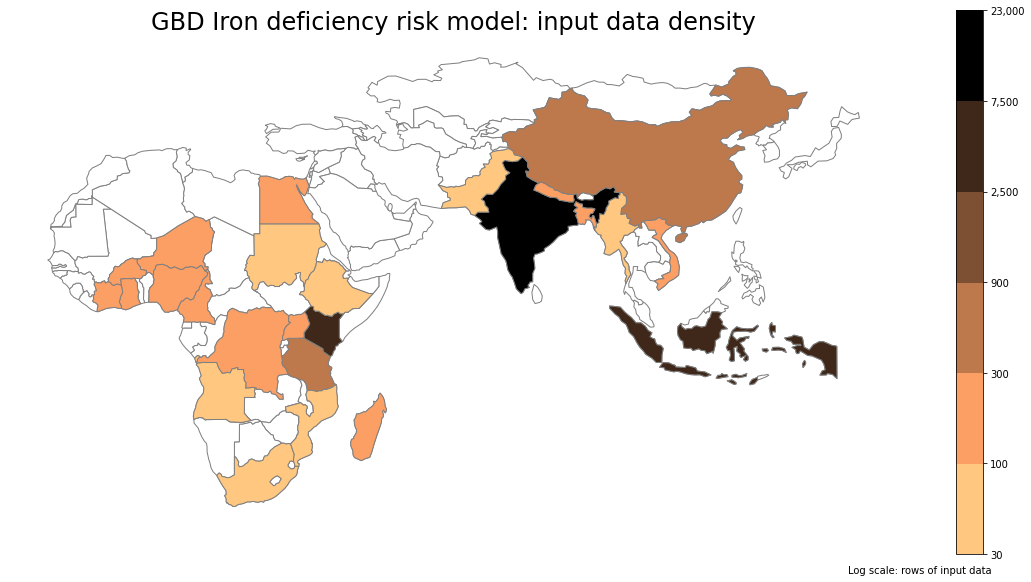

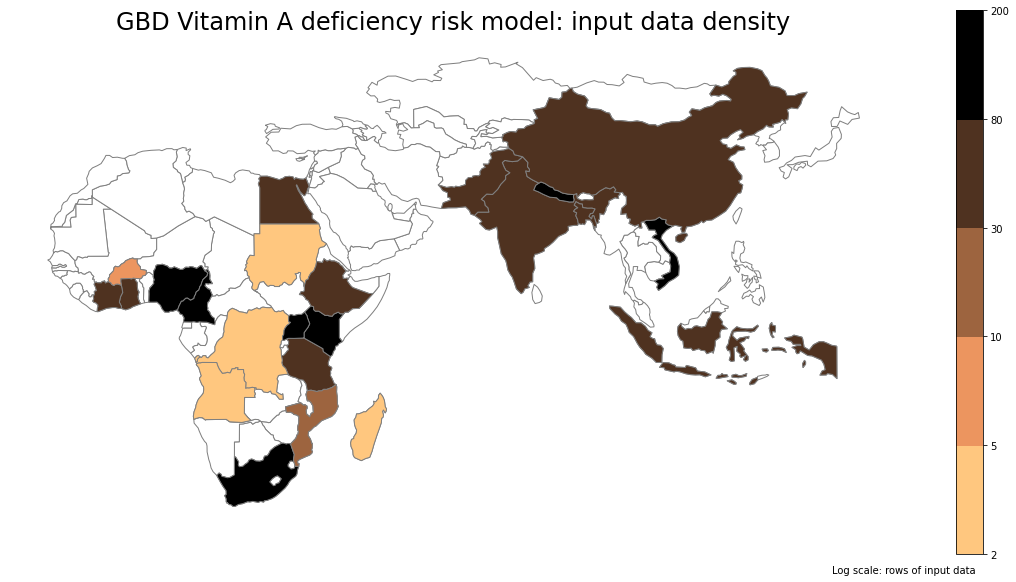

In [22]:
def map_risk_input_data_density(rf, n_colors):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_aspect('equal')
    ax.set_title(f'GBD {rf} risk model: input data density', fontsize = 24)
    ax.set_axis_off() #remove latlon ticks + box surrounding map


    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax,
                                                               color = 'white',
                                                               edgecolor='gray')

    rf_df = shapefiles[shapefiles.Risk==rf]
    scale_max = rf_df.log_nrows.max()
    scale_min = rf_df.log_nrows.min()

    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('copper_r', n_colors) #colorscale, discretized to n_colors bins
    norm = mpl.colors.Normalize(vmin=scale_min, vmax=scale_max) #normalize color scale
    me = rf_df.plot(ax=base,
                    column='log_nrows',
                    cmap=cmap,
                    edgecolor = 'gray')
    
    # add colorbar
    ticks = np.arange(scale_min, scale_max+1, (scale_max - scale_min)/n_colors)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=me, ticks = ticks)
    
    # exponentiate and round to clean - looking numbers for labeling
    tick_labels = [add_commas(round_ticks(np.exp(i))) for i in ticks]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.set_label('Log scale: rows of input data', labelpad=-105, y=-.02, rotation=0)

    
risk_n_colors_dict = {
    'Iron deficiency':6,
    'Vitamin A deficiency':5,
    'Zinc deficiency':3,
    'Neural tube defect':5
}


save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/gbd_iron_vad_risk_input_data_density_map.pdf'

pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
for rf in ['Iron deficiency', 'Vitamin A deficiency']:
    fig =  map_risk_input_data_density(rf, n_colors = risk_n_colors_dict[rf])
    pdf.savefig(fig)
pdf.close()

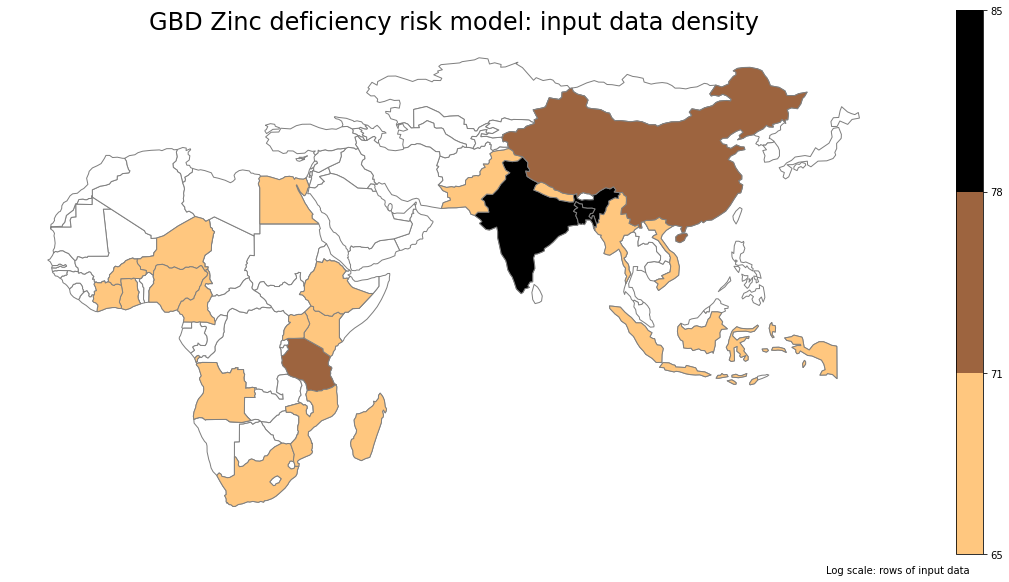

In [23]:
def map_zinc_input_data_density(rf, n_colors):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_aspect('equal')
    ax.set_title(f'GBD {rf} risk model: input data density', fontsize = 24)
    ax.set_axis_off() #remove latlon ticks + box surrounding map


    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax,
                                                               color = 'white',
                                                               edgecolor='gray')

    # subset to var of interest
    rf_df = shapefiles[shapefiles.Risk==rf]
    scale_max = rf_df.log_nrows.max()
    scale_min = rf_df.log_nrows.min()

    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('copper_r', n_colors) #colorscale, discretized to n_colors bins
    norm = mpl.colors.Normalize(vmin=scale_min, vmax=scale_max) #normalize color scale
    me = rf_df.plot(ax=base,
                    column='log_nrows',
                    cmap=cmap,
                    edgecolor = 'gray')
    # add colorbar
    ticks = np.arange(scale_min, scale_max+1, (scale_max - scale_min)/n_colors)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=me, ticks = ticks)
    
    # exponentiate and convert to int for clean tick labels (this one has only small vals)
    tick_labels = [str(int(np.exp(i))) for i in ticks]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.set_label('Log scale: rows of input data', labelpad=-105, y=-.02, rotation=0)

    
risk_n_colors_dict = {
    'Iron deficiency':6,
    'Vitamin A deficiency':5,
    'Zinc deficiency':3,
    'Neural tube defect':5
}


save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/gbd_zinc_risk_input_data_density_map.pdf'

pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
for rf in ['Zinc deficiency']:
    fig =  map_zinc_input_data_density(rf, n_colors = risk_n_colors_dict[rf])
    pdf.savefig(fig)
pdf.close()